<a href="https://colab.research.google.com/github/xmukova/MIP_clanok/blob/main/ZNEUS_projekt_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***ZNEUS*** <br> <br>

***Projekt 2 - Katarína Kačmarová Maďarová, Alena Múková*** <br> <br>

***Inamge classification - ASL dataset*** <br> <br>

--------------------

**Načítanie dát**

In [ ]:
import torch
from torchvision import transforms
from torchvision import datasets
from torchvision.datasets import ImageFolder
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
import hashlib
from torch.utils.data import DataLoader, random_split

torch.manual_seed(42)

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle (3).json


In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d kapillondhe/american-sign-language


Dataset URL: https://www.kaggle.com/datasets/kapillondhe/american-sign-language
License(s): GPL-2.0
User cancelled operation


In [ ]:
!mkdir /content/asl
!unzip -q american-sign-language.zip -d /content/asl


mkdir: cannot create directory ‘/content/asl’: File exists
replace /content/asl/ASL_Dataset/Test/A/3001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls /content/asl


ASL_Dataset


**Data analysis**

V datasete https://www.kaggle.com/datasets/kapillondhe/american-sign-language máme 2 priečinky - Test a Train. Predpokladáme, že naše dáta sú už rozdelené na trénovaciu a testovaciu množinu. Každý priečinok obsahuje ďalšie priečinky s jednotlivými rozdelenými znakmi abecedy. Môžeme však vidieť, že Testovací priečinok má pre každú triedu iba 4 vzorky. To je veľmi málo a preto sme sa rozhodli, že urobíme vlastný data split na Train dátach.

In [ ]:
cesta_train = "/content/asl/ASL_Dataset/Train"
cesta_test = "/content/asl/ASL_Dataset/Test"

print("Train folders:", os.listdir(cesta_train))
print("Test folders:", os.listdir(cesta_test))

Train folders: ['H', 'U', 'D', 'F', 'K', 'Y', 'L', 'R', 'X', 'E', 'S', 'C', 'Nothing', 'Q', 'I', 'Z', 'A', 'P', 'G', 'T', 'M', 'B', 'Space', 'O', 'J', 'W', 'N', 'V']
Test folders: ['H', 'U', 'D', 'F', 'K', 'Y', 'L', 'R', 'X', 'E', 'S', 'C', 'Nothing', 'Q', 'I', 'Z', 'A', 'P', 'G', 'T', 'M', 'B', 'Space', 'O', 'J', 'W', 'N', 'V']


Pocet obrazkov v Train:
 {'A': 5996, 'B': 5996, 'C': 5996, 'D': 5996, 'E': 5996, 'F': 5996, 'G': 5996, 'H': 5996, 'I': 5996, 'J': 5996, 'K': 5996, 'L': 5996, 'M': 5996, 'N': 5996, 'Nothing': 5996, 'O': 5996, 'P': 5996, 'Q': 5996, 'R': 5966, 'S': 5996, 'Space': 5886, 'T': 5648, 'U': 4542, 'V': 5996, 'W': 5996, 'X': 5996, 'Y': 5720, 'Z': 5996}
Pocet obrazkov v Test:
 {'A': 4, 'B': 4, 'C': 4, 'D': 4, 'E': 4, 'F': 4, 'G': 4, 'H': 4, 'I': 4, 'J': 4, 'K': 4, 'L': 4, 'M': 4, 'N': 4, 'Nothing': 4, 'O': 4, 'P': 4, 'Q': 4, 'R': 4, 'S': 4, 'Space': 4, 'T': 4, 'U': 4, 'V': 4, 'W': 4, 'X': 4, 'Y': 4, 'Z': 4}



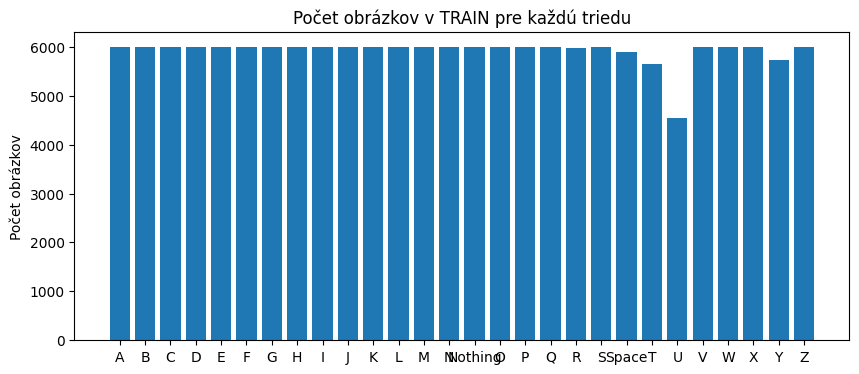

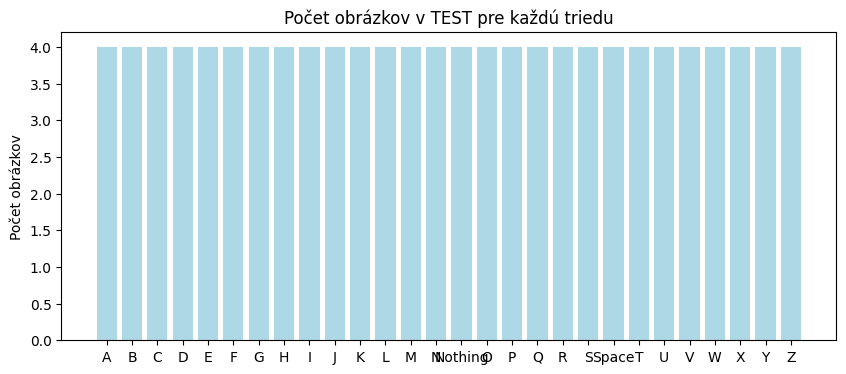

In [ ]:
def count_images(base_path):
    counts = {}
    for i in sorted(os.listdir(base_path)):
        cesta = os.path.join(base_path, i)
        if os.path.isdir(cesta):
            counts[i] = len(os.listdir(cesta))
    return counts

train_pocet = count_images(cesta_train)
test_pocet = count_images(cesta_test)
print("Pocet obrazkov v Train:\n", train_pocet)
print("Pocet obrazkov v Test:\n", test_pocet)
print()

plt.figure(figsize=(10,4))
plt.bar(train_pocet.keys(), train_pocet.values())
plt.title("Počet obrázkov v TRAIN pre každú triedu")
plt.ylabel("Počet obrázkov")
plt.show()

plt.figure(figsize=(10,4))
plt.bar(test_pocet.keys(), test_pocet.values(), color="lightblue")
plt.title("Počet obrázkov v TEST pre každú triedu")
plt.ylabel("Počet obrázkov")
plt.show()

In [ ]:
def get_image_sizes(path):
    widths, heights = [], []
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                try:
                    with Image.open(img_path) as img:
                        w, h = img.size
                        widths.append(w)
                        heights.append(h)
                except:
                    pass
    return np.array(widths), np.array(heights)

train_w, train_h = get_image_sizes("/content/asl/ASL_Dataset/Train")
print("Priemerná veľkosť obrázka:", train_w.mean(), "x", train_h.mean())
print("Štandardná odchýlka:", train_w.std(), "x", train_h.std())

Priemerná veľkosť obrázka: 400.0 x 400.0
Štandardná odchýlka: 0.0 x 0.0


In [ ]:
broken = []
for cls in os.listdir(cesta_train):
    folder = os.path.join(cesta_train, cls)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            Image.open(img_path).verify()
        except:
            broken.append(img_path)

print("Poškodené obrázky:", len(broken))

Poškodené obrázky: 2


In [ ]:
def hash_file(path):
    with open(path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()
hashes = {}
duplicates = []
for cls in os.listdir(cesta_train):
    cls_path = os.path.join(cesta_train, cls)
    for img_name in os.listdir(cls_path):
        p = os.path.join(cls_path, img_name)
        h = hash_file(p)
        if h in hashes:
            duplicates.append((p, hashes[h]))
        else:
            hashes[h] = p
print("Duplikáty:", len(duplicates))

KeyboardInterrupt: 

In [ ]:
def show_samples(cls, n=9):
    cls_path = os.path.join(cesta_train, cls)
    imgs = os.listdir(cls_path)[:n]
    plt.figure(figsize=(6,6))
    for i, img_name in enumerate(imgs):
        img = Image.open(os.path.join(cls_path, img_name))
        plt.subplot(3,3,i+1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")
    plt.show()

show_samples("A")
show_samples("B")
show_samples("C")
show_samples("Space")


**Data split**

Dáta sme rozdelili nasledovne:
- 70 % trénovacie dáta
- 15 % validačné dáta
- 15 % testovacie dáta

In [ ]:
data_vsetko = datasets.ImageFolder(root=cesta_train, transform=None)
print("Počet obrázkov:", len(data_vsetko))
print("Triedy:", data_vsetko.classes)


Počet obrázkov: 165670
Triedy: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'Nothing', 'O', 'P', 'Q', 'R', 'S', 'Space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [ ]:
n_total = len(data_vsetko)
n_train = int(0.70 * n_total)
n_valid = int(0.15 * n_total)
n_test = n_total - n_train - n_valid

data_train, data_valid, data_test = random_split(data_vsetko, [n_train, n_valid, n_test])

print("Trénovacie dáta:", len(data_train))
print("Validačné dáta:  ", len(data_valid))
print("Testovacie dáta: ", len(data_test))


Trénovacie dáta: 115968
Validačné dáta:   24850
Testovacie dáta:  24852


**Data preprocessing and normalization**

In [ ]:
image_size = 64
transform_basic_z_train = transforms.Compose([transforms.Resize((image_size, image_size)), transforms.ToTensor()])  #prevod na tenzor a zmena velkosti na 64x64
data_for_stats_vsetko = datasets.ImageFolder(cesta_train, transform=transform_basic_z_train)        #nacitanbie vsetkych obrazkov
train_stats_dataset = torch.utils.data.Subset(data_for_stats_vsetko, data_train.indices)            #vyber len trenovacich obrazkov


In [ ]:
#vypocet iba z podmnoziny train, lebo to dlho trvalo
subset = torch.utils.data.Subset(train_stats_dataset, range(10000))

loader = DataLoader(subset, batch_size=128, num_workers=2)
mean = 0
std = 0
total = 0
for images, _ in loader:
    batch = images.size(0)
    images = images.view(batch, 3, -1)
    mean += images.mean(2).sum(0)
    std  += images.std(2).sum(0)
    total += batch
mean = mean / total
std = std / total
print("Mean: ", mean)
print("Std: ", std)

Mean:  tensor([0.5616, 0.5297, 0.5126])
Std:  tensor([0.0968, 0.1579, 0.1765])


In [ ]:
train_preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())])

valid_test_preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())])

# DATASETYYYY
train_dataset = torch.utils.data.Subset(datasets.ImageFolder(cesta_train, transform=train_preprocess), data_train.indices)
valid_dataset = torch.utils.data.Subset(datasets.ImageFolder(cesta_train, transform=valid_test_preprocess), data_valid.indices)
test_dataset = torch.utils.data.Subset(datasets.ImageFolder(cesta_train, transform=valid_test_preprocess), data_test.indices)


In [ ]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


**Augmentations**